# Project 2

In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

ReLU activation function

In [9]:
def relu(x):
    return jnp.maximum(0.0, x)

Sigmoid activation function

In [10]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

Softmax activation function

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    # Subtraction of max improves numerical stability
    e_x = jnp.exp(x - jnp.max(x, axis=-1, keepdims=True))
    return e_x / jnp.sum(e_x, axis=-1, keepdims=True)

Flexible neural network architecture with initial random weights and biases

In [12]:
in_dim = 1
out_dim = 1
hidden_dims = [2]          
num_layers = len(hidden_dims) + 1

weights = []
biases = []

class NeuralNetwork:
    def __init__(self, in_dim, out_dim, hidden_dims, key, init_type="standard"):
        """
        init_type: "standard" for N(0, 1) or "xavier" for Xavier/Glorot weighting
        """
        self.layer_dims = [in_dim] + hidden_dims + [out_dim]
        self.num_layers = len(self.layer_dims) - 1
        self.init_type = init_type # Store the initialization choice

        self.params = self.init_params(key)

    def init_params(self, key):
        params = []
        keys = jax.random.split(key, self.num_layers)

        for i in range(self.num_layers):
            k = keys[i]
            n_in = self.layer_dims[i]
            n_out = self.layer_dims[i + 1]
            
            # Draw from standard normal distribution N(0, 1)
            W = jax.random.normal(k, (n_in, n_out))
            
            # Apply weighting based on choice 
            if self.init_type == "xavier":
                stddev = jnp.sqrt(2.0 / (n_in + n_out))
                W = W * stddev
            # If init_type is "standard", W remains N(0, 1)
            
            b = jnp.zeros((n_out,))
            params.append((W, b))

        return params


def forward(params, x, activation):
    h = x
    for i, (W, b) in enumerate(params):
        z = h @ W + b
        if i < len(params) - 1:
            h = activation(z)
        else:
            h = z
    return h


MSE Loss

In [13]:
def mse_loss(params,  x, y_true, activation):
    y_pred = forward(params, x, activation)
    return jnp.mean((y_pred - y_true) ** 2)


Training step using automatic differentation from JAX

In [14]:
from functools import partial

@partial(jax.jit,  static_argnames=("activation",))
def train_step(params, x, y, lr, activation):
    loss, grads = jax.value_and_grad(mse_loss)(params, x, y, activation)

    new_params = [
        (W - lr * dW, b - lr * db)
        for (W, b), (dW, db) in zip(params, grads)
    ]

    return new_params, loss

from functools import partial

Simplest initial example, $ y = Ax + b$.

In [15]:
# Dimensions
num_samples = 10

# Input data
x = jnp.linspace(0, 1, num_samples).reshape(-1, in_dim)

# Random ground-truth linear model
key = jax.random.PRNGKey(16)
key_A, key_b = jax.random.split(key)

A_true = jax.random.normal(key_A, (in_dim, out_dim))
b_true = jax.random.normal(key_b, (out_dim,))

# Generate targets
y = x @ A_true + b_true

print(y)


[[0.6478221 ]
 [0.77399504]
 [0.90016794]
 [1.0263408 ]
 [1.1525137 ]
 [1.2786868 ]
 [1.4048597 ]
 [1.5310326 ]
 [1.6572056 ]
 [1.7833784 ]]


Initialise and train network

In [16]:
lr = 3*1e-1
model = NeuralNetwork(in_dim, out_dim, hidden_dims, key)
params = model.params
activation = relu

losses = []

for epoch in range(2000):
    params, loss = train_step(params, x, y, lr, activation)

    losses.append(loss)

    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss: {loss:.12f}")

epoch 0, loss: 0.735022246838
epoch 100, loss: 0.000000000000
epoch 200, loss: 0.000000000000
epoch 300, loss: 0.000000000000
epoch 400, loss: 0.000000000000
epoch 500, loss: 0.000000000000
epoch 600, loss: 0.000000000000
epoch 700, loss: 0.000000000000
epoch 800, loss: 0.000000000000
epoch 900, loss: 0.000000000000
epoch 1000, loss: 0.000000000000
epoch 1100, loss: 0.000000000000
epoch 1200, loss: 0.000000000000
epoch 1300, loss: 0.000000000000
epoch 1400, loss: 0.000000000000
epoch 1500, loss: 0.000000000000
epoch 1600, loss: 0.000000000000
epoch 1700, loss: 0.000000000000
epoch 1800, loss: 0.000000000000
epoch 1900, loss: 0.000000000000


In [17]:
y_pred = forward(params, x, activation)
print("Predictions:", y_pred)
print("True targets:", y)

Predictions: [[0.64782226]
 [0.77399516]
 [0.90016806]
 [1.026341  ]
 [1.1525139 ]
 [1.2786868 ]
 [1.4048595 ]
 [1.5310326 ]
 [1.6572053 ]
 [1.7833782 ]]
True targets: [[0.6478221 ]
 [0.77399504]
 [0.90016794]
 [1.0263408 ]
 [1.1525137 ]
 [1.2786868 ]
 [1.4048597 ]
 [1.5310326 ]
 [1.6572056 ]
 [1.7833784 ]]


Final prediction

## 2. Handwritten digits classification
### Data Acquisition
In accordance with the project suggestions, we use the `scikit-learn` library to retrieve the MNIST dataset. This dataset contains 70,000 grayscale images of handwritten digits (0-9), each of size $28 \times 28$ pixels.

In [18]:
from sklearn.datasets import fetch_openml
import numpy as np

# Fetching the MNIST dataset (784 features correspond to 28x28 flattened pixels)
print("Loading MNIST dataset...")
mnist = fetch_openml("mnist_784", version=1, as_frame=False) 

# X contains the flattened vector representations of the images
# y contains the corresponding labels (0-9)
X, y = mnist["data"], mnist["target"].astype(np.uint8) 

print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features.")

Loading MNIST dataset...
Dataset loaded: 70000 samples with 784 features.


### Data Visualization
To better understand the dataset we are working with, the following cell implements a function to visualize individual MNIST images from their flattened vector representations.

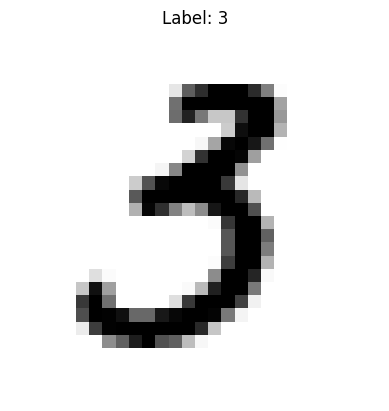

In [19]:
import matplotlib.pyplot as plt

def plot_digit(data, label):
    """
    Visualizes a single MNIST digit.
    Reshapes the 784 flattened vector back to a 28x28 image.
    """
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Example: visualizing the first image of the dataset
plot_digit(X[789], y[789])

## 2.a. Training of the neural network with cross-entropy loss and mini-batch gradient descent.

#### One-Hot Encoding
Since the MNIST labels are integers from 0 to 9, we need to transform them into binary vectors of size 10. This **one-hot encoding** allows the network to compare its 10-way output probabilities with the ground truth during the loss calculation.

In [20]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

#### Loss Function 
We then define the **Categorical Cross-Entropy Loss**, which is the standard objective function for such tasks.

In [21]:
def cross_entropy_loss(params, x, y_true, activation):
    """Multiclass Cross-Entropy Loss."""
    # Forward pass through the network
    logits = forward(params, x, activation)
    
    # Apply softmax to get probabilities
    probs = softmax(logits)
    
    # Compute cross-entropy: -sum(y_true * log(probs))
    # We add a small epsilon (1e-9) to avoid log(0)
    return -jnp.mean(jnp.sum(y_true * jnp.log(probs + 1e-9), axis=-1))

#### Accuracy Metric
While the loss function is used for optimization, **accuracy** provides a human-readable performance metric. It calculates the percentage of images correctly classified by comparing the index of the highest predicted probability with the true label.

In [22]:
def accuracy(params, x, y_true, activation):
    """Computes the accuracy of the model."""
    logits = forward(params, x, activation)
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == y_true)

#### Data Normalization
The raw pixel values in `X` range from 0 to 255. To ensure numerical stability and prevent gradients from vanishing or exploding during the training of our `NeuralNetwork`, we scale these values to the range $[0, 1]$ by dividing by 255.

In [23]:
# Normalizing the feature matrix
X_normalized = X / 255.0

print(f"Original range: {X.min()} to {X.max()}")
print(f"Normalized range: {X_normalized.min()} to {X_normalized.max()}")

Original range: 0 to 255
Normalized range: 0.0 to 1.0


#### Train-Test Split
We split our dataset into a training set (to optimize the parameters) and a testing set (to evaluate final performance). We use 80% of the data for training and 20% for testing. We also convert these arrays into `jax.numpy` arrays to leverage JAX's computational speed.

In [24]:
from sklearn.model_selection import train_test_split

# 1. Splitting into 80% train/validation pool and 20% final test
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42
)

# 2. Converting to JAX arrays 
X_train_full = jnp.array(X_train_raw)
X_test = jnp.array(X_test_raw)
y_train_full = jnp.array(y_train_raw)
y_test = jnp.array(y_test_raw)

print(f"Training pool (X_train_full): {X_train_full.shape[0]} images")
print(f"Final test set (X_test): {X_test.shape[0]} images")

Training pool (X_train_full): 56000 images
Final test set (X_test): 14000 images


#### k-fold cross-validation
As requested in the project instructions, we implement a **k-fold cross-validation** ($k=5$) combined with a **grid search** to select the best hyperparameters. This approach ensures that our model's performance is not dependent on a specific train-validation split.

In [25]:
from sklearn.model_selection import KFold

# Defining K=5 folds as suggested in the instructions
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print(f"Setup complete for {num_folds}-fold cross-validation.")

Setup complete for 5-fold cross-validation.


#### Training Step for Classification
We update our training step to handle the multiclass classification task. Unlike the previous version used for regression, this function utilizes the **Categorical Cross-Entropy Loss**. It is decorated with `@jax.jit` to compile the function for faster execution and uses `jax.value_and_grad` to automatically compute the gradients of the loss with respect to the network parameters.

In [27]:
@partial(jax.jit, static_argnames=("activation",))
def train_step_classification(params, x_batch, y_batch, lr, activation):
    # Calcul de la perte et des gradients sur le batch actuel
    loss, grads = jax.value_and_grad(cross_entropy_loss)(params, x_batch, y_batch, activation)
    
    # Mise à jour des paramètres (SGD)
    new_params = [
        (W - lr * dW, b - lr * db)
        for (W, b), (dW, db) in zip(params, grads)
    ]
    return new_params, loss

#### Mini-batch Gradient Descent Implementation
To follow the project requirements, we implement a training loop that processes data in mini-batches. This approach provides a balance between the stability of full-batch gradient descent and the efficiency of stochastic gradient descent. We also include a shuffling mechanism at each epoch to ensure the model does not learn the order of the data.

In [28]:
def train_model_batches(X_train, y_train, config, key):
    """
    Trains the network using mini-batch gradient descent.
    """
    # 1. Initialization
    model = NeuralNetwork(
        in_dim=784, 
        out_dim=10, 
        hidden_dims=config['architecture'], 
        key=key, 
        init_type=config['init_type']
    )
    params = model.params
    y_train_oh = one_hot(y_train, 10) # Format labels for Cross-Entropy
    
    num_samples = X_train.shape[0]
    batch_size = config['batch_size']
    num_batches = num_samples // batch_size
    
    # Track losses for the learning curves requested in Question 2a
    epoch_losses = []

    for epoch in range(config['epochs']):
        # Shuffle data at the start of each epoch
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, num_samples)
        X_shuffled = X_train[perm]
        y_shuffled_oh = y_train_oh[perm]
        
        total_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            
            # Update parameters using only the current batch
            params, loss = train_step_classification(
                params, 
                X_shuffled[start:end], 
                y_shuffled_oh[start:end], 
                config['lr'], 
                config['activation']
            )
            total_loss += loss
            
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        
    return params, epoch_losses

def init_network(layer_sizes, init_type="xavier", key=jax.random.PRNGKey(0)):
    """
    Initializes the weights and biases for a dense neural network.
    """
    params = []
    keys = jax.random.split(key, len(layer_sizes) - 1)
    
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i+1]
        
        if init_type == "xavier":
            # Xavier/Glorot initialization: std = sqrt(1 / n_in)
            std = jnp.sqrt(1.0 / n_in)
            w = jax.random.normal(keys[i], (n_out, n_in)) * std
        else:
            # Simple small normal initialization
            w = jax.random.normal(keys[i], (n_out, n_in)) * 0.01
            
        b = jnp.zeros((n_out,))
        params.append((w, b))
        
    return params

### Hyperparameters
We define the grid of hyperparameters to explore, including hidden layer architectures, learning rates, batch sizes and activation functions as specified in the assignment.
### Optimization Strategy
To comply with the requirement of selecting "promising hyperparameters", we implement a nested loop. The outer loop iterates through our **Grid Search** configurations, while the inner loop performs a **5-fold Cross-Validation**. This process ensures that the reported accuracy is an average across different data splits, providing a reliable measure of the model's generalization capability.

**Warning**

This will take a long time to run, whoever is marking this Notebook might want to make the parameter grid smaller.

In [30]:
import itertools
import numpy as np

# 1. Define the hyperparameter grid as specified in the project 
param_grid = {
    'architecture': [[128], [128, 64], [128, 64, 32]],
    'lr': [0.01, 0.1, 0.2],
    'batch_size': [16, 32],
    'epochs': [10],
    'activation': [relu, sigmoid],
    'init_type': ["xavier"]
}

# Generate all unique combinations from the grid
keys, values = zip(*param_grid.items())
grid_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_config = None
best_avg_acc = -1.0
best_params = None
results_log = []

print(f"Starting Grid Search: {len(grid_combinations)} combinations x {num_folds} folds.\n")

# 2. Outer Loop: Iterate through each hyperparameter configuration 
for config in grid_combinations:
    fold_accuracies = []
    print(f"Testing Config: Arch={config['architecture']}, LR={config['lr']}, Batch={config['batch_size']}, Activation={config['activation']}")
    
    # 3. Inner Loop: Perform K-Fold Cross-Validation (K=5) 
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        # Split the training pool into training and validation folds for this iteration
        X_fold_train, X_fold_val = X_train_full[train_idx], X_train_full[val_idx]
        y_fold_train, y_fold_val = y_train_full[train_idx], y_train_full[val_idx]
        
        # Train the model using the mini-batch gradient descent function [cite: 30]
        key = jax.random.PRNGKey(fold) 
        params, _ = train_model_batches(X_fold_train, y_fold_train, config, key)
        
        # Evaluate performance on the validation fold
        val_acc = accuracy(params, X_fold_val, y_fold_val, config['activation'])
        fold_accuracies.append(val_acc)
    
    # Calculate the average accuracy across all 5 folds for this configuration
    avg_acc = np.mean(fold_accuracies)
    results_log.append({'config': config, 'avg_acc': avg_acc})
    print(f"  -> Average Val Accuracy: {avg_acc:.4f}\n")
    
    # Save the best configuration and parameters found so far
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_config = config
        best_params = params # Prevents 'best_params not defined' error later

print("--- Grid Search Complete ---")
print(f"Best Config found: {best_config}")
print(f"Best Validation Accuracy: {best_avg_acc:.4f}")

Starting Grid Search: 36 combinations x 5 folds.

Testing Config: Arch=[128], LR=0.01, Batch=16, Activation=<function relu at 0x743ab3279580>
  -> Average Val Accuracy: 0.9571

Testing Config: Arch=[128], LR=0.01, Batch=16, Activation=<function sigmoid at 0x743ab3279440>
  -> Average Val Accuracy: 0.9152

Testing Config: Arch=[128], LR=0.01, Batch=32, Activation=<function relu at 0x743ab3279580>
  -> Average Val Accuracy: 0.9427

Testing Config: Arch=[128], LR=0.01, Batch=32, Activation=<function sigmoid at 0x743ab3279440>
  -> Average Val Accuracy: 0.9016

Testing Config: Arch=[128], LR=0.1, Batch=16, Activation=<function relu at 0x743ab3279580>
  -> Average Val Accuracy: 0.9769

Testing Config: Arch=[128], LR=0.1, Batch=16, Activation=<function sigmoid at 0x743ab3279440>
  -> Average Val Accuracy: 0.9655

Testing Config: Arch=[128], LR=0.1, Batch=32, Activation=<function relu at 0x743ab3279580>
  -> Average Val Accuracy: 0.9748

Testing Config: Arch=[128], LR=0.1, Batch=32, Activatio

Report the accuracy and learning curves for the best model.

Epoch 1/10, Loss: 0.217360
Epoch 2/10, Loss: 0.097791
Epoch 3/10, Loss: 0.073466
Epoch 4/10, Loss: 0.053703
Epoch 5/10, Loss: 0.042350
Epoch 6/10, Loss: 0.034043
Epoch 7/10, Loss: 0.026835
Epoch 8/10, Loss: 0.021711
Epoch 9/10, Loss: 0.016092
Epoch 10/10, Loss: 0.012688
Validation/Test Accuracy: 0.9782


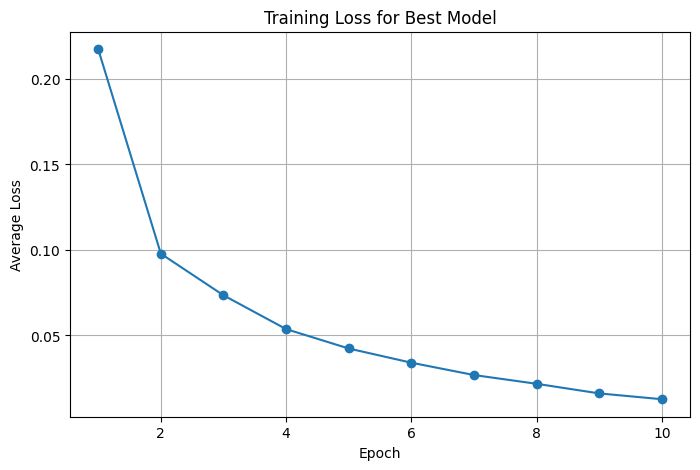

In [31]:
import matplotlib.pyplot as plt

def evaluate_best_model(X_train, y_train, X_val, y_val, best_config, key):
    """
    Re-train the model using the best hyperparameters on the full training data,
    and keep track of epoch losses for plotting learning curves.
    
    Args:
        X_train: Training feature matrix
        y_train: Training labels
        X_val: Validation or test feature matrix
        y_val: Validation or test labels
        best_config: Dictionary with the best hyperparameters (architecture, lr, batch_size, etc.)
        key: JAX PRNGKey for random initialization

    Returns:
        best_params: Trained model parameters
        epoch_losses: List of average training loss per epoch
        val_accuracy: Accuracy on the validation/test set
    """
    
    # 1. Initialize the neural network with best configuration
    model = NeuralNetwork(
        in_dim=784,
        out_dim=10,
        hidden_dims=best_config['architecture'],
        key=key,
        init_type=best_config.get('init_type', 'xavier')
    )
    params = model.params
    activation = best_config['activation']
    
    # One-hot encode the training labels for cross-entropy
    y_train_oh = one_hot(y_train, 10)
    
    num_samples = X_train.shape[0]
    batch_size = best_config['batch_size']
    num_batches = num_samples // batch_size
    
    epoch_losses = []

    # 2. Training loop
    for epoch in range(best_config['epochs']):
        # Shuffle the training data at the start of each epoch
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, num_samples)
        X_shuffled = X_train[perm]
        y_shuffled_oh = y_train_oh[perm]
        
        total_loss = 0
        # Mini-batch gradient descent
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            params, loss = train_step_classification(
                params,
                X_shuffled[start:end],
                y_shuffled_oh[start:end],
                best_config['lr'],
                activation
            )
            total_loss += loss
        
        # Compute average loss for the epoch
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Optional: print progress every ~10% of epochs
        if epoch % max(1, best_config['epochs'] // 10) == 0:
            print(f"Epoch {epoch+1}/{best_config['epochs']}, Loss: {avg_loss:.6f}")
    
    # 3. Compute final accuracy on validation/test set
    val_accuracy = accuracy(params, X_val, y_val, activation)
    print(f"Validation/Test Accuracy: {val_accuracy:.4f}")
    
    return params, epoch_losses, val_accuracy


def plot_learning_curve(epoch_losses, title="Learning Curve"):
    """
    Plot the training loss over epochs.
    
    Args:
        epoch_losses: List of average loss per epoch
        title: Plot title
    """
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ------------------------------
# Example usage:

key = jax.random.PRNGKey(123)  # New PRNGKey for final training

best_params, epoch_losses, val_acc = evaluate_best_model(
    X_train_full, 
    y_train_full, 
    X_test,         # Use the test set for final evaluation
    y_test,
    best_config,
    key
)

plot_learning_curve(epoch_losses, title="Training Loss for Best Model")


## 2.b. Influence of Hypermarameters on CPU time and accuracy
We first vary batch size


Testing batch_size = 16
Epoch 1/10, Loss: 0.214866
Epoch 2/10, Loss: 0.098546
Epoch 3/10, Loss: 0.069354
Epoch 4/10, Loss: 0.051908
Epoch 5/10, Loss: 0.041152
Epoch 6/10, Loss: 0.033302
Epoch 7/10, Loss: 0.026583
Epoch 8/10, Loss: 0.020747
Epoch 9/10, Loss: 0.015055
Epoch 10/10, Loss: 0.011921
Validation/Test Accuracy: 0.9767

Testing batch_size = 32
Epoch 1/10, Loss: 0.249465
Epoch 2/10, Loss: 0.108972
Epoch 3/10, Loss: 0.076381
Epoch 4/10, Loss: 0.058018
Epoch 5/10, Loss: 0.046081
Epoch 6/10, Loss: 0.036851
Epoch 7/10, Loss: 0.029585
Epoch 8/10, Loss: 0.024441
Epoch 9/10, Loss: 0.019155
Epoch 10/10, Loss: 0.015105
Validation/Test Accuracy: 0.9760

Testing batch_size = 64
Epoch 1/10, Loss: 0.313788
Epoch 2/10, Loss: 0.149603
Epoch 3/10, Loss: 0.108292
Epoch 4/10, Loss: 0.084372
Epoch 5/10, Loss: 0.069545
Epoch 6/10, Loss: 0.058544
Epoch 7/10, Loss: 0.050112
Epoch 8/10, Loss: 0.043016
Epoch 9/10, Loss: 0.037731
Epoch 10/10, Loss: 0.031907
Validation/Test Accuracy: 0.9766

Testing batc

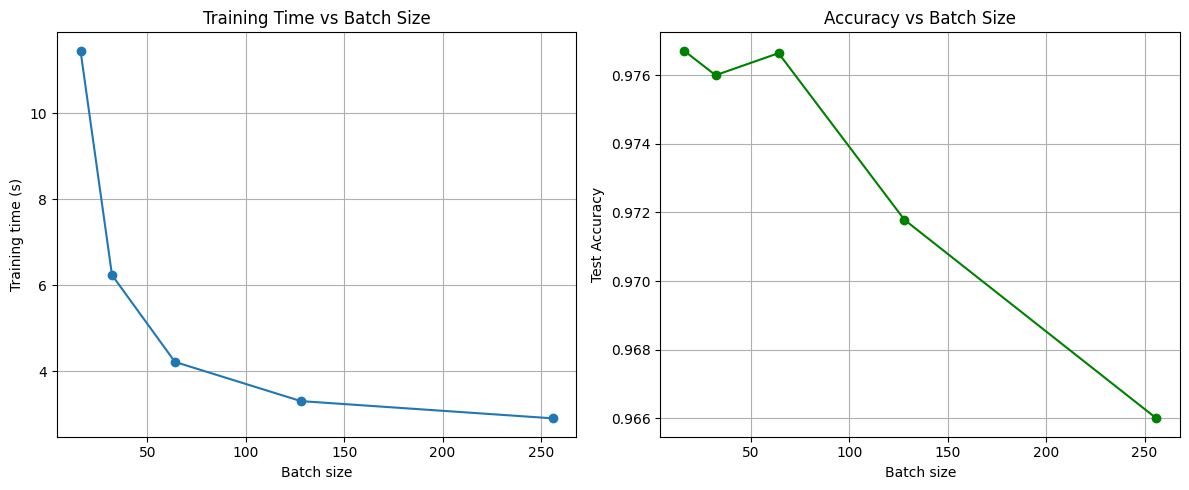

In [34]:
import time

# -----------------------------------------------
# 1. Varying batch size
# -----------------------------------------------

def study_batch_size(X_train, y_train, X_test, y_test, best_config, key):
    """
    Study the effect of different batch sizes on training time and final accuracy.
    """
    batch_sizes = [16, 32, 64, 128, 256]  # powers of 2, reasonable for MNIST
    times = []
    accuracies = []
    
    for batch_size in batch_sizes:
        print(f"\nTesting batch_size = {batch_size}")
        
        # Update the config with new batch size
        config = best_config.copy()
        config['batch_size'] = batch_size
        
        start_time = time.time()
        
        # Train the model with this batch size
        key, subkey = jax.random.split(key)
        params, _ , val_acc = evaluate_best_model(
            X_train, y_train,
            X_test, y_test,
            config,
            subkey
        )
        end_time = time.time()
        
        elapsed = end_time - start_time
        times.append(elapsed)
        accuracies.append(val_acc)
        
    # Plot results
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(batch_sizes, times, marker='o')
    plt.xlabel("Batch size")
    plt.ylabel("Training time (s)")
    plt.title("Training Time vs Batch Size")
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(batch_sizes, accuracies, marker='o', color='green')
    plt.xlabel("Batch size")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs Batch Size")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return batch_sizes, times, accuracies

# -----------------------------------------------
# Example usage
# -----------------------------------------------
key = jax.random.PRNGKey(1234)

# Study batch size effect
batch_sizes, batch_times, batch_accs = study_batch_size(
    X_train_full, y_train_full,
    X_test, y_test,
    best_config,
    key
) 

Then, we vary learning rate


Testing learning rate = 0.0001
Epoch 1/10, Loss: 2.224390
Epoch 2/10, Loss: 1.903612
Epoch 3/10, Loss: 1.647378
Epoch 4/10, Loss: 1.431134
Epoch 5/10, Loss: 1.255964
Epoch 6/10, Loss: 1.117352
Epoch 7/10, Loss: 1.008097
Epoch 8/10, Loss: 0.921411
Epoch 9/10, Loss: 0.851840
Epoch 10/10, Loss: 0.795200
Validation/Test Accuracy: 0.8296

Testing learning rate = 0.001
Epoch 1/10, Loss: 1.354693
Epoch 2/10, Loss: 0.645033
Epoch 3/10, Loss: 0.493536
Epoch 4/10, Loss: 0.430228
Epoch 5/10, Loss: 0.393965
Epoch 6/10, Loss: 0.369563
Epoch 7/10, Loss: 0.351422
Epoch 8/10, Loss: 0.337072
Epoch 9/10, Loss: 0.325025
Epoch 10/10, Loss: 0.314784
Validation/Test Accuracy: 0.9126

Testing learning rate = 0.01
Epoch 1/10, Loss: 0.513916
Epoch 2/10, Loss: 0.287145
Epoch 3/10, Loss: 0.240459
Epoch 4/10, Loss: 0.207475
Epoch 5/10, Loss: 0.182922
Epoch 6/10, Loss: 0.163532
Epoch 7/10, Loss: 0.147930
Epoch 8/10, Loss: 0.135081
Epoch 9/10, Loss: 0.124409
Epoch 10/10, Loss: 0.115283
Validation/Test Accuracy: 0.

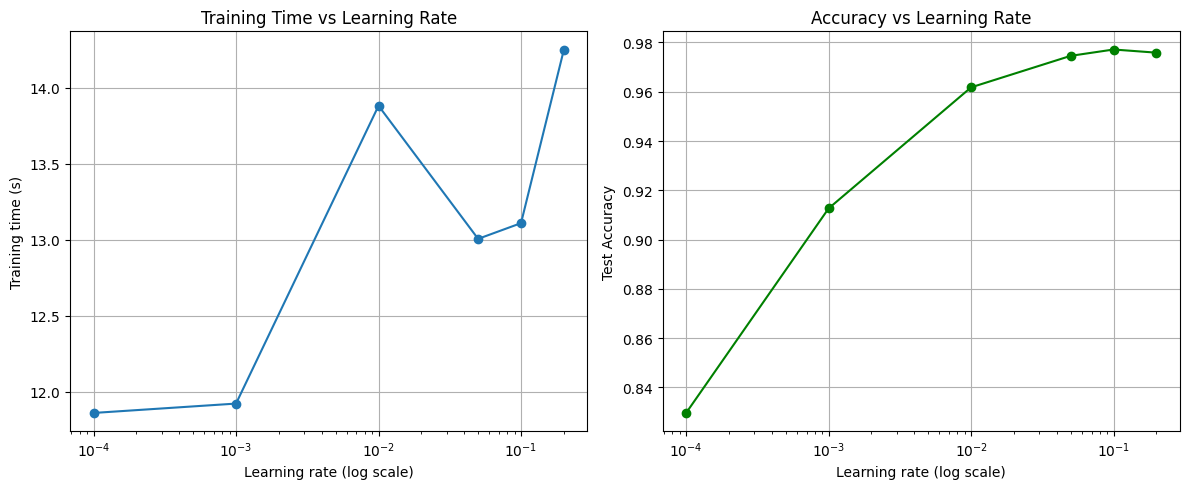

In [35]:
# -----------------------------------------------
# 2. Varying learning rate
# -----------------------------------------------

def study_learning_rate(X_train, y_train, X_test, y_test, best_config, key):
    """
    Study the effect of different learning rates on training time and final accuracy.
    """
    learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]  # covers too small to too large
    times = []
    accuracies = []
    
    for lr in learning_rates:
        print(f"\nTesting learning rate = {lr}")
        
        # Update the config with new learning rate
        config = best_config.copy()
        config['lr'] = lr
        
        start_time = time.time()
        
        # Train the model with this learning rate
        key, subkey = jax.random.split(key)
        params, _, val_acc = evaluate_best_model(
            X_train, y_train,
            X_test, y_test,
            config,
            subkey
        )
        end_time = time.time()
        
        elapsed = end_time - start_time
        times.append(elapsed)
        accuracies.append(val_acc)
    
    # Plot results
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(learning_rates, times, marker='o')
    plt.xscale('log')
    plt.xlabel("Learning rate (log scale)")
    plt.ylabel("Training time (s)")
    plt.title("Training Time vs Learning Rate")
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(learning_rates, accuracies, marker='o', color='green')
    plt.xscale('log')
    plt.xlabel("Learning rate (log scale)")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs Learning Rate")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return learning_rates, times, accuracies

# -----------------------------------------------
# Example usage
# -----------------------------------------------
key = jax.random.PRNGKey(1234)

# Study learning rate effect
learning_rates, lr_times, lr_accs = study_learning_rate(
    X_train_full, y_train_full,
    X_test, y_test,
    best_config,
    key
)

Now, we look at the differen activation functions.

In [38]:
def study_activation(X_train, y_train, X_test, y_test, best_config, key):
    """
    Study the effect of different learning rates on training time and final accuracy.
    """
    activations = [relu, sigmoid]
    activation_labels = ["ReLU", "Sigmoid"]
    times = []
    accuracies = []
    
    for activation in activations:
        print(f"\nTesting activation = {activation}")
        
        # Update the config with new learning rate
        config = best_config.copy()
        config['activation'] = activation
        
        start_time = time.time()
        
        # Train the model with this learning rate
        key, subkey = jax.random.split(key)
        params, _, val_acc = evaluate_best_model(
            X_train, y_train,
            X_test, y_test,
            config,
            subkey
        )
        end_time = time.time()
        
        elapsed = end_time - start_time
        times.append(elapsed)
        accuracies.append(val_acc)
    

    return activations, activation_labels, times, accuracies

key = jax.random.PRNGKey(1234)

# Study learning rate effect
activations, activation_labels, act_times, act_accs = study_activation(
    X_train_full, y_train_full,
    X_test, y_test,
    best_config,
    key
)

for i in range(len(activations)):
    print(f"Activation: {activation_labels[i]}, Time: {act_times[i]:.2f}s, Accuracy: {act_accs[i]:.4f}")


Testing activation = <function relu at 0x743ab3279580>
Epoch 1/10, Loss: 0.214866
Epoch 2/10, Loss: 0.098546
Epoch 3/10, Loss: 0.069354
Epoch 4/10, Loss: 0.051908
Epoch 5/10, Loss: 0.041152
Epoch 6/10, Loss: 0.033302
Epoch 7/10, Loss: 0.026583
Epoch 8/10, Loss: 0.020747
Epoch 9/10, Loss: 0.015055
Epoch 10/10, Loss: 0.011921
Validation/Test Accuracy: 0.9767

Testing activation = <function sigmoid at 0x743ab3279440>
Epoch 1/10, Loss: 0.362608
Epoch 2/10, Loss: 0.193868
Epoch 3/10, Loss: 0.140618
Epoch 4/10, Loss: 0.110029
Epoch 5/10, Loss: 0.089712
Epoch 6/10, Loss: 0.075664
Epoch 7/10, Loss: 0.064723
Epoch 8/10, Loss: 0.056237
Epoch 9/10, Loss: 0.048929
Epoch 10/10, Loss: 0.043190
Validation/Test Accuracy: 0.9715
Activation: ReLU, Time: 11.59s, Accuracy: 0.9767
Activation: Sigmoid, Time: 11.46s, Accuracy: 0.9715


Finally we look at the effect of varying the architecture.

In [39]:
def study_architecture(X_train, y_train, X_test, y_test, best_config, key):
    """
    Study the effect of different learning rates on training time and final accuracy.
    """
    arches = [[128], [128, 64], [128, 64, 32]]
    arch_labels = ["128", "128-64", "128-64-32"]
    times = []
    accuracies = []
    
    for arch in arches:
        print(f"\nTesting architecture = {arch}")
        
        # Update the config with new learning rate
        config = best_config.copy()
        config['architecture'] = arch
        
        start_time = time.time()
        
        # Train the model with this learning rate
        key, subkey = jax.random.split(key)
        params, _, val_acc = evaluate_best_model(
            X_train, y_train,
            X_test, y_test,
            config,
            subkey
        )
        end_time = time.time()
        
        elapsed = end_time - start_time
        times.append(elapsed)
        accuracies.append(val_acc)
    
    plt.figure(figsize=(12, 5))

    # --- Training time bar chart ---
    plt.subplot(1, 2, 1)
    plt.bar(arch_labels, times)
    plt.xlabel("Architecture")
    plt.ylabel("Training Time (s)")
    plt.title("Training Time by Architecture")
    plt.grid(axis="y")

    # --- Accuracy bar chart ---
    plt.subplot(1, 2, 2)
    plt.bar(arch_labels, accuracies)
    plt.xlabel("Architecture")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy by Architecture")
    plt.grid(axis="y")

    plt.tight_layout()
    plt.show()
    
    return arches, times, accuracies

# -----------------------------------------------
# Example usage
# -----------------------------------------------
key = jax.random.PRNGKey(1234)

# Study learning rate effect
learning_rates, lr_times, lr_accs = study_learning_rate(
    X_train_full, y_train_full,
    X_test, y_test,
    best_config,
    key
)


Testing learning rate = 0.0001
Epoch 1/10, Loss: 2.224390
Epoch 2/10, Loss: 1.903612
Epoch 3/10, Loss: 1.647378
Epoch 4/10, Loss: 1.431134
Epoch 5/10, Loss: 1.255964
Epoch 6/10, Loss: 1.117352
Epoch 7/10, Loss: 1.008097
Epoch 8/10, Loss: 0.921411
Epoch 9/10, Loss: 0.851840
Epoch 10/10, Loss: 0.795200
Validation/Test Accuracy: 0.8296

Testing learning rate = 0.001
Epoch 1/10, Loss: 1.354693
Epoch 2/10, Loss: 0.645033
Epoch 3/10, Loss: 0.493536


KeyboardInterrupt: 

## 2.c. Analysis of Misclassified Images
After training our best model, we evaluate it on the test set to identify images where the prediction does not match the true label. Visualizing these errors helps us understand if the mistakes are due to ambiguous handwriting or inherent limitations of our dense network architecture.

In [ ]:
# 1. Get predictions on the test set
test_logits = forward(best_params, X_test, relu) # Use your best activation
test_predictions = jnp.argmax(test_logits, axis=-1)

# 2. Find indices where predictions differ from true labels
# Note: y_test is already jnp.array from our split step
misclassified_indices = jnp.where(test_predictions != y_test)[0]

print(f"Number of misclassified images: {len(misclassified_indices)} out of {len(y_test)}")

Number of misclassified images: 303 out of 14000


#### Visualization of Misclassified Images (Question 2c)
To analyze the model's performance, we identify instances in the test set where the predicted label differs from the ground truth. Visualizing these 10 examples allows us to discuss possible reasons for failure, such as ambiguous handwriting or the limitations of flattened vector representations.

Total misclassified in test set: 303 / 14000


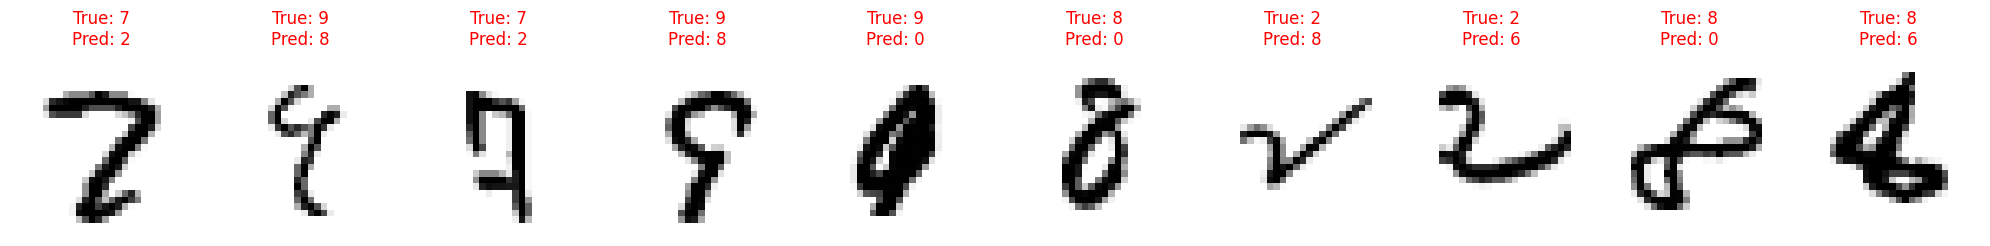

In [ ]:
import matplotlib.pyplot as plt

# 1. Generate predictions for the entire test set using the best parameters
# We use the activation function defined in our best_config
test_logits = forward(best_params, X_test, best_config['activation'])
test_predictions = jnp.argmax(test_logits, axis=-1)

# 2. Identify indices where the prediction is incorrect
# y_test contains the true labels (0-9)
misclassified_indices = jnp.where(test_predictions != y_test)[0]

print(f"Total misclassified in test set: {len(misclassified_indices)} / {len(y_test)}")

# 3. Plot 10 misclassified images
num_to_show = 10
plt.figure(figsize=(20, 4))

for i in range(num_to_show):
    idx = misclassified_indices[i]
    image = X_test[idx].reshape(28, 28)
    true_label = y_test[idx]
    pred_label = test_predictions[idx]
    
    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(image, cmap='binary')
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()